In [1]:
import pandas as pd
from dfply import *
import matplotlib.pyplot as plt
import missingno as msno
from datetime import timedelta
import time
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
import sys
sys.path.append('/Users/sdc/Documents/bida_lab/db/P1_extubationfailure/서대철')
# 데이터 정제 시 필요한 모듈들
import src.subjectlist_alignment.pairing as pairing   # 삽관 발관 페어링 관련 모듈
from src.subjectlist_alignment import reintubation as rnt   # 재삽관 시간 계산 관련 모듈
from src.subjectlist_alignment import imputation as imp   # 결측치 대체 관련 모듈
from src.subjectlist_alignment import subject_classification as cls
import sys
sys.path.append('/Users/sdc/Documents/bida_lab/db/P1_extubationfailure/서대철')
import src.utils.utils as utils   # 기타 유틸리티 모듈
import src.data_extraction.access_database as db   # DB 연결 관련 모듈

In [2]:
# 변수를 붙일 subjectlist 데이터 가져오기

data_dir = '../outputs/subjectlist1_imputed_categorized.csv'
subjectlist1 = pd.read_csv(data_dir, index_col=0)

# datetime 변환
time_cols = ['admittime', 'intubationtime', 'extubationtime', 'dischtime', 'deathtime', 'reintubation_eventtime']
subjectlist1 = utils.to_datetime(subjectlist1, time_cols)
print(subjectlist1.shape)
subjectlist1.head()

Converted admittime to datetime.
Converted intubationtime to datetime.
Converted extubationtime to datetime.
Converted dischtime to datetime.
Converted deathtime to datetime.
Converted reintubation_eventtime to datetime.
(9003, 27)


,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,...,reintubation_eventtime,reintubationtime,seq_num,mvtime,final_event,ext_to_death,ext_to_disch,disch_to_death,class_code,class
0,10001884,26184834,37510196.0,2131-01-07 20:39:00,2131-01-11 04:30:00,224385.0,65.0,37510196.0,2131-01-12 17:40:00,227194.0,...,NaT,NaN,1,False,True,10775.0,10775.0,0.0,11,nonfailure
1,10003400,23559586,38383343.0,2137-08-04 00:07:00,2137-08-17 21:21:00,224385.0,90.5,38383343.0,2137-08-21 15:40:00,227194.0,...,NaT,NaN,1,False,True,17365.0,17365.0,0.0,11,nonfailure
2,10004401,27939719,31202136.0,2144-04-11 03:31:00,2144-04-11 05:03:00,224385.0,120.0,NaN,2144-04-13 15:00:00,NaN,...,NaT,NaN,1,False,True,NaN,151.0,NaN,121,nonfailure
3,10004401,29988601,32773003.0,2144-01-23 07:58:00,2144-01-27 19:00:00,224385.0,76.0,32773003.0,2144-01-30 12:30:00,227194.0,...,2144-01-30 13:00:00,30.0,1,False,False,NaN,10035.0,NaN,211,failure
4,10004401,29988601,32773003.0,2144-01-23 07:58:00,2144-01-30 13:00:00,224385.0,76.0,NaN,2144-02-02 04:00:00,NaN,...,NaT,NaN,2,False,True,NaN,6225.0,NaN,221,nonfailure


### stay id mismatch 케이스

In [7]:
# int stayid != ext stayid 케이스
def mark_stayid_mismatch(df):
    """
    삽관 발관 이벤트의 stay_id가 안 맞는 케이스를 마킹함.
    """

    df['stayid_mismatch'] = df.apply(
        lambda row: pd.notnull(row['int_stayid']) and pd.notnull(row['ext_stayid']) and row['int_stayid'] != row['ext_stayid'],
        axis=1
    )
    return df

subjectlist1 = mark_stayid_mismatch(subjectlist1)
test_sublist = subjectlist1[subjectlist1.stayid_mismatch == True]
test_sublist

,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,...,reintubationtime,seq_num,mvtime,final_event,ext_to_death,ext_to_disch,disch_to_death,class_code,class,stayid_mismatch
23,10030579,27018952,35640251.0,2183-08-18 12:20:00,2183-08-18 13:30:00,224385.0,74.3,38210605.0,2183-08-19 15:30:00,227194.0,...,NaN,1,False,True,NaN,8564.0,NaN,11,nonfailure,True
89,10122589,28594240,30741193.0,2180-04-07 14:40:00,2180-04-09 08:00:00,224385.0,80.0,33850138.0,2180-04-10 15:05:00,225468.0,...,NaN,2,False,True,NaN,1475.0,NaN,2221,nonfailure,True
349,10390732,26272149,39439439.0,2143-07-26 19:43:00,2143-07-31 03:25:00,224385.0,69.0,36756755.0,2143-08-07 09:48:00,227194.0,...,2974.0,1,False,False,NaN,26142.0,NaN,212,nonfailure,True
442,10495665,23675676,39279580.0,2158-09-29 17:59:00,2158-09-29 19:00:00,224385.0,88.0,36086196.0,2158-10-06 16:19:00,227194.0,...,NaN,1,False,True,NaN,17006.0,NaN,11,nonfailure,True
447,10501162,24511516,32581914.0,2191-06-23 04:42:00,2191-06-23 19:16:00,224385.0,87.5,33217006.0,2191-07-07 14:00:00,227194.0,...,NaN,2,False,True,NaN,27337.0,NaN,221,nonfailure,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8390,19374979,21633271,39014058.0,2146-10-02 09:18:00,2146-10-03 17:00:00,224385.0,79.6,30582233.0,2146-10-18 13:20:00,227194.0,...,NaN,2,False,True,40.0,40.0,0.0,22221,death,True
8695,19666282,28290120,34565195.0,2153-05-31 15:59:00,2153-06-06 15:45:00,224385.0,63.8,38193913.0,2153-06-11 16:35:00,227194.0,...,NaN,1,False,True,NaN,12775.0,NaN,11,nonfailure,True
8877,19855099,23924601,39989651.0,2169-02-23 13:39:00,2169-02-23 17:00:00,224385.0,80.0,33738626.0,2169-03-08 09:07:00,227194.0,...,NaN,1,False,True,NaN,10632.0,NaN,11,nonfailure,True
8909,19890030,26070834,31527285.0,2178-08-28 01:12:00,2178-09-07 13:50:00,224385.0,53.2,37655051.0,2178-09-09 11:03:00,227194.0,...,NaN,3,False,True,NaN,5984.0,NaN,221,nonfailure,True


In [14]:
hadm_ids = test_sublist.hadm_id.unique()
test_sublist.hadm_id.nunique()

98

In [12]:
# transfer 테이블 가져오기
# DB 연결 테이블 후 가져오기

database_config = {'database': 'mimic4',
 'user': 'postgres',
 'password': '1234',
 'host': 'localhost',
 'port': 5432}

tables_query = {'transfer': "select * from mimiciv_hosp.transfers;"}

db.print_config_info(database_config, tables_query)
conn = db.connect_to_database(database_config)
dataframes = db.retrieve_data(conn, tables_query)
db.disconnect_database(conn)

# pg_tables = dataframes['pg_tables']
# patients = dataframes['patients']
# d_items = dataframes['d_items']

transfer = dataframes['transfer']

INFO:root:CONNECTING TO DATABASE...


--------- Database Configuration ---------
Database Name: mimic4
User: postgres
Password: ****
Host: localhost
Port: 5432

--------- SQL Queries for Required Tables ---------
transfer: select * from mimiciv_hosp.transfers;



INFO:root:Retrieved transfer: (1890972, 7)
INFO:root:DATABASE CONNCETION CLOSED.


In [13]:
transfer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1890972 entries, 0 to 1890971
Data columns (total 7 columns):
 #   Column       Dtype         
---  ------       -----         
 0   subject_id   int64         
 1   hadm_id      float64       
 2   transfer_id  int64         
 3   eventtype    object        
 4   careunit     object        
 5   intime       datetime64[ns]
 6   outtime      datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(2), object(2)
memory usage: 101.0+ MB


In [16]:
transfer.head()

,subject_id,hadm_id,transfer_id,eventtype,careunit,intime,outtime
0,10000032,22595853.0,33258284,ED,Emergency Department,2180-05-06 19:17:00,2180-05-06 23:30:00
1,10000032,22595853.0,35223874,admit,Transplant,2180-05-06 23:30:00,2180-05-07 17:21:27
2,10000032,22595853.0,36904543,discharge,None,2180-05-07 17:21:27,NaT
3,10000032,22841357.0,34100253,discharge,None,2180-06-27 18:49:12,NaT
4,10000032,22841357.0,34703856,admit,Transplant,2180-06-26 21:31:00,2180-06-27 18:49:12


In [35]:
len(hadm_ids)

98

In [40]:
hadm_id = hadm_ids[88]
print(hadm_id)

26859252


In [41]:
subjectlist1[subjectlist1.hadm_id == hadm_id]

,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,...,reintubationtime,seq_num,mvtime,final_event,ext_to_death,ext_to_disch,disch_to_death,class_code,class,stayid_mismatch
8031,18959634,26859252,36741627.0,2164-05-14 18:41:00,2164-05-21 11:44:00,224385.0,74.0,32666035.0,2164-05-29 08:50:00,227194.0,...,5530.0,1,False,False,6338.0,6338.0,0.0,212,nonfailure,True
8032,18959634,26859252,32666035.0,2164-05-14 18:41:00,2164-06-02 05:00:00,224385.0,74.0,NaN,2164-06-02 12:00:00,NaN,...,NaN,2,True,True,388.0,388.0,0.0,22221,death,False


In [42]:
transfer[transfer.hadm_id == hadm_id].sort_values(by='intime')

,subject_id,hadm_id,transfer_id,eventtype,careunit,intime,outtime
1696161,18959634,26859252.0,30226139,ED,Emergency Department,2164-05-14 14:59:00,2164-05-14 20:14:00
1696168,18959634,26859252.0,37982649,admit,Trauma SICU (TSICU),2164-05-14 20:14:00,2164-05-18 14:17:19
1696165,18959634,26859252.0,35964550,transfer,Surgery/Trauma,2164-05-18 14:17:19,2164-05-18 22:07:27
1696164,18959634,26859252.0,35145809,transfer,Surgery/Trauma,2164-05-18 22:07:27,2164-05-21 11:02:31
1696167,18959634,26859252.0,36741627,transfer,Coronary Care Unit (CCU),2164-05-21 11:02:31,2164-05-21 20:38:08
1696162,18959634,26859252.0,30592598,transfer,Surgical Intensive Care Unit (SICU),2164-05-21 20:38:08,2164-05-23 18:07:21
1696169,18959634,26859252.0,39190217,transfer,Discharge Lounge,2164-05-23 18:07:21,2164-05-23 18:07:31
1696163,18959634,26859252.0,32666035,transfer,Surgical Intensive Care Unit (SICU),2164-05-23 18:07:31,2164-06-02 22:41:36
1696166,18959634,26859252.0,36220386,discharge,None,2164-06-02 22:41:36,NaT


In [39]:
subjectlist1[subjectlist1.hadm_id == hadm_id]

,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,...,reintubationtime,seq_num,mvtime,final_event,ext_to_death,ext_to_disch,disch_to_death,class_code,class,stayid_mismatch
7127,17877210,23937337,30215114.0,2125-04-01 14:50:00,2125-04-04 09:54:00,224385.0,65.0,30215114.0,2125-04-05 15:45:00,227194.0,...,3975.0,1,False,False,NaN,28589.0,NaN,212,nonfailure,False
7128,17877210,23937337,30215114.0,2125-04-01 14:50:00,2125-04-08 10:00:00,224385.0,65.0,38153470.0,2125-04-09 12:06:00,227194.0,...,NaN,2,False,True,NaN,23048.0,NaN,221,nonfailure,True


-----

### 새로운 분류

In [58]:
subjectlist1[subjectlist1.mvtime == False]['class_code'].value_counts().sum()

6159

In [59]:
subjectlist1['class'].value_counts()

class
nonfailure    6170
failure       1313
death         1273
Name: count, dtype: int64

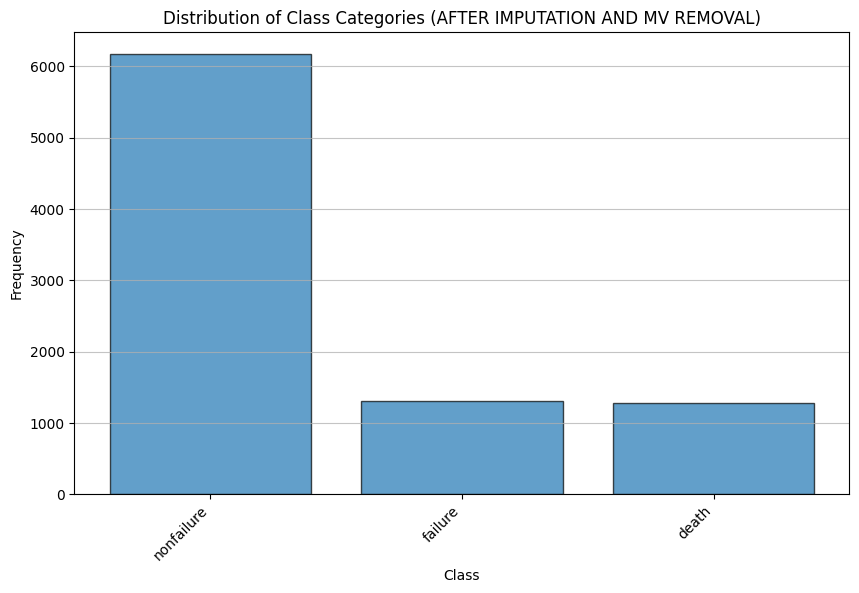

In [61]:
# Desired order for the categories
order = ['nonfailure', 'failure', 'death']
class_counts = subjectlist1['class'].value_counts()
# Reordering the class_counts dictionary according to the specified order
# This ensures that when we plot, the bars follow this order.
reordered_counts = {key: class_counts[key] for key in order}

# Creating the bar chart
plt.figure(figsize=(10, 6))
plt.bar(reordered_counts.keys(), reordered_counts.values(), edgecolor='k', alpha=0.7)
plt.title('Distribution of Class Categories (AFTER IMPUTATION AND MV REMOVAL)')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.show()

-----

### null case 살펴보기 / ventilation 함수 테스트하기

In [63]:
subjectlist_cleaned = subjectlist1[subjectlist1.mvtime == False]
subjectlist_cleaned

,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,...,reintubationtime,seq_num,mvtime,final_event,ext_to_death,ext_to_disch,disch_to_death,class_code,class,stayid_mismatch
0,10001884,26184834,37510196.0,2131-01-07 20:39:00,2131-01-11 04:30:00,224385.0,65.0,37510196.0,2131-01-12 17:40:00,227194.0,...,NaN,1,False,True,10775.0,10775.0,0.0,11,nonfailure,False
1,10003400,23559586,38383343.0,2137-08-04 00:07:00,2137-08-17 21:21:00,224385.0,90.5,38383343.0,2137-08-21 15:40:00,227194.0,...,NaN,1,False,True,17365.0,17365.0,0.0,11,nonfailure,False
2,10004401,27939719,31202136.0,2144-04-11 03:31:00,2144-04-11 05:03:00,224385.0,120.0,NaN,2144-04-13 15:00:00,NaN,...,NaN,1,False,True,NaN,151.0,NaN,121,nonfailure,False
3,10004401,29988601,32773003.0,2144-01-23 07:58:00,2144-01-27 19:00:00,224385.0,76.0,32773003.0,2144-01-30 12:30:00,227194.0,...,30.0,1,False,False,NaN,10035.0,NaN,211,failure,False
4,10004401,29988601,32773003.0,2144-01-23 07:58:00,2144-01-30 13:00:00,224385.0,76.0,NaN,2144-02-02 04:00:00,NaN,...,NaN,2,False,True,NaN,6225.0,NaN,221,nonfailure,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8996,19995595,21784060,34670930.0,2126-10-17 21:43:00,2126-10-31 00:45:00,224385.0,94.7,34670930.0,2126-11-03 16:20:00,227194.0,...,NaN,2,False,True,NaN,13035.0,NaN,221,nonfailure,False
8998,19997367,20617667,35616526.0,2126-04-20 07:15:00,2126-04-26 20:14:00,224385.0,59.0,35616526.0,2126-05-02 16:30:00,227194.0,...,4430.0,2,False,False,NaN,24345.0,NaN,212,nonfailure,False
8999,19997367,20617667,35616526.0,2126-04-20 07:15:00,2126-05-05 18:20:00,224385.0,59.0,35616526.0,2126-05-08 17:29:00,227194.0,...,NaN,3,False,True,NaN,15646.0,NaN,221,nonfailure,False
9000,19999068,21606769,30143796.0,2161-08-24 04:10:00,2161-08-25 15:34:00,224385.0,55.8,30143796.0,2161-08-28 13:35:00,227194.0,...,NaN,1,False,True,NaN,7525.0,NaN,11,nonfailure,False


In [73]:
null_case = subjectlist_cleaned[subjectlist_cleaned.class_code == 9999]

In [66]:
# DB 연결 테이블 후 가져오기
# ventilation 테이블
database_config = {'database': 'mimic4',
 'user': 'postgres',
 'password': '1234',
 'host': 'localhost',
 'port': 5432}

tables_query = {'ventilation': "select * from mimiciv_derived.ventilation;"}

db.print_config_info(database_config, tables_query)
conn = db.connect_to_database(database_config)
dataframes = db.retrieve_data(conn, tables_query)
db.disconnect_database(conn)

# pg_tables = dataframes['pg_tables']
# patients = dataframes['patients']
# d_items = dataframes['d_items']

ventilation = dataframes['ventilation']

INFO:root:CONNECTING TO DATABASE...


--------- Database Configuration ---------
Database Name: mimic4
User: postgres
Password: ****
Host: localhost
Port: 5432

--------- SQL Queries for Required Tables ---------
ventilation: select * from mimiciv_derived.ventilation;



INFO:root:Retrieved ventilation: (111237, 4)
INFO:root:DATABASE CONNCETION CLOSED.


In [69]:
subjectlist_cleaned[subjectlist_cleaned.int_stayid == 32359580]

,subject_id,hadm_id,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,...,reintubationtime,seq_num,mvtime,final_event,ext_to_death,ext_to_disch,disch_to_death,class_code,class,stayid_mismatch
6,10007818,22987108,32359580.0,2146-06-10 16:37:00,2146-06-22 12:49:00,224385.0,86.2,NaN,NaT,NaN,...,NaN,1,False,True,NaN,NaN,1250.0,9999,NaN,False


In [68]:
ventilation[ventilation.stay_id == 32359580]

,stay_id,starttime,endtime,ventilation_status
26497,32359580,2146-06-22 13:00:00,2146-07-12 15:00:00,InvasiveVent


In [72]:
import pandas as pd
import numpy as np

def find_approx_single_vent(ventilation_df, row):
    """
    Ventilation 테이블에서 현재 행의 결측된 intubationtime 또는 extubationtime의 대체 가능한 값을 찾습니다. 
    
    Parameters:
    - ventilation_df: ventilation 테이블
    - row: Series 타입의 환자 행 데이터 (행 단위로 함수 적용됨)
    
    Returns:
    - 딕셔너리: 원본 행(결측치 포함)과 대체 가능한 가장 적합한 후보군 (candiates). 적절한 후보가 없을 경우 None.
    - 입력된 행에 결측치가 없을 경우, None을 리턴.
    """
    
    # intubationtime, extubationtime 모두 있을 경우 패스
    if pd.notnull(row['intubationtime']) and pd.notnull(row['extubationtime']):
        return None  # Indicating that no action is needed for this row
    
    results = {'original_times': None, 'candidate_times': None}
    
    # 결측 시간에 따라 올바른 stay_id 할당 (int missing -> ext stay id; ext missing -> int stay id 사용)
    stayid = row['ext_stayid'] if pd.isnull(row['intubationtime']) else row['int_stayid']
    target_time = 'endtime' if pd.isnull(row['extubationtime']) else 'starttime'
    known_time = row['intubationtime'] if target_time == 'endtime' else row['admittime']
    compare_time = row['dischtime'] if target_time == 'endtime' else row['extubationtime']
    
    # 원래 시간 기록
    results['original_times'] = {'intubationtime': row.get('intubationtime'), 'extubationtime': row.get('extubationtime')}
    
    # 결측 시간에 따라 후보 필터링
    candidates = ventilation_df[ventilation_df['stay_id'] == stayid]
    candidates = candidates[(candidates[target_time] > known_time) & (candidates[target_time] < compare_time)]
    
    if len(candidates) > 1:
        candidates['time_diff'] = (candidates[target_time] - known_time).abs()
        min_diff = candidates['time_diff'].min()
        closest_candidates = candidates[candidates['time_diff'] == min_diff]
        
        # corrected_time_type을 여기서 정의하여 변수명 통일
        corrected_time_type = "extubationtime" if target_time == "endtime" else "intubationtime"
        
        if len(closest_candidates) == 1:
            # 가장 적합한 후보 시간 기록
            results['candidate_times'] = {corrected_time_type: pd.Timestamp(closest_candidates[target_time].values[0])}
        else:
            # 가장 가까운 후보 시간 모두 기록
            results['candidate_times'] = {corrected_time_type: [pd.Timestamp(time) for time in closest_candidates[target_time].values]}

    elif len(candidates) == 1:
        # corrected_time_type을 사용하기 전에 정의
        corrected_time_type = "extubationtime" if target_time == "endtime" else "intubationtime"
        # 단일 후보 시간 기록
        results['candidate_times'] = {corrected_time_type: pd.Timestamp(candidates[target_time].values[0])}
    else:
        print("No candidate rows found.")

    
    return results if results['candidate_times'] else None


def find_best_candidate_for_imputation(ventilation_df, row, prev_row=None, next_row=None):
    """
    (여러 시퀀스가 있는 환자의 행 데이터에 적용)
    결측된 intubationtime 또는 extubationtime에 대한 최적의 후보 타임스탬프를 찾습니다.
    'ext_stayid'는 'intubationtime'이 결측될 때 사용하고, 'int_stayid'는 'extubationtime'이 결측될 때 사용합니다.
    """
    
    # intubationtime과 extubationtime이 모두 존재하는지 확인 (존재하면 건너뛰기)
    if pd.notnull(row['intubationtime']) and pd.notnull(row['extubationtime']):
        return []
    
    results = []
    stay_id = row['ext_stayid'] if pd.isnull(row['intubationtime']) else row['int_stayid']
    
    if pd.isnull(row['intubationtime']):
        candidates = ventilation_df[(ventilation_df['stay_id'] == stay_id) &
                                    (ventilation_df['starttime'] < row.get('extubationtime', np.inf)) &
                                    (ventilation_df['starttime'] > prev_row.get('extubationtime', row['admittime']))]
        if not candidates.empty:
            # 여러 starttime이 존재할 경우 그들의 'endtime'을 참조해서 비교
            candidates['time_diff'] = (candidates['endtime'] - row.get('extubationtime', np.inf)).abs()
            best_candidate_idx = candidates['time_diff'].idxmin()
            results.append(('intubationtime', candidates.loc[best_candidate_idx, 'starttime']))
            
    elif pd.isnull(row['extubationtime']):
        candidates = ventilation_df[(ventilation_df['stay_id'] == stay_id) &
                                    (ventilation_df['endtime'] > row.get('intubationtime', -np.inf)) &
                                    (ventilation_df['endtime'] < next_row.get('intubationtime', row['dischtime']))]
        if not candidates.empty:
            # 여러 endtime이 존재할 경우 그들의 'starttime'을 참조
            candidates['time_diff'] = (candidates['starttime'] - row.get('intubationtime', -np.inf)).abs()
            best_candidate_idx = candidates['time_diff'].idxmin()
            results.append(('extubationtime', candidates.loc[best_candidate_idx, 'endtime']))

    return results


def process_ventilation_sequences(ventilation_df, group):
    """
    한 환자(=group)의 ventilation 이벤트를 처리하여 누락된 데이터에 대한 최적의 후보를 찾습니다.
    intubationtime과 extubationtime이 모두 존재하는 행은 건너뜁니다.
    """
    imputation_candidates = []

    for idx, row in group.iterrows():
        # 이번 행에 결측 없는 경우 다음 행으로 이동
        if pd.notnull(row['intubationtime']) and pd.notnull(row['extubationtime']):
            continue

        prev_row = group[group['seq_num'] == row['seq_num'] - 1].iloc[0] if row['seq_num'] > 1 else pd.Series()
        next_row = group[group['seq_num'] == row['seq_num'] + 1].iloc[0] if row['seq_num'] < group['seq_num'].max() else pd.Series()

        current_pair = {'intubationtime': row.get('intubationtime'), 'extubationtime': row.get('extubationtime')}

        if row.get('reint_marker', False):
            candidates = find_best_candidate_for_imputation(ventilation_df, row, prev_row, next_row)
            if candidates:
                # 오리지널 행과 후보군 함께 저장 (비교 위해)
                imputation_candidates.append({'index': idx, 'current_pair': current_pair, 'candidates': candidates})

    return imputation_candidates



def ventilation_search(ventilation_df, subject_df):
    """
    ventilation 테이블을 이용해 결측된 삽관/발관 시간을 찾는 메인 함수.
    """

    grouped_df = subject_df.groupby(['subject_id', 'hadm_id'])

    single_row_results_list = []
    multirow_candidates_list = []

    for (subject_id, hadm_id), group in grouped_df:
        if len(group) == 1:
            # 1번째 칼럼 인덱스로 활용
            index = group.index[0]  # 데이터프레임 넘버링 되어 있어야 함.
            single_row = group.iloc[0]
            single_row_results = find_approx_single_vent(ventilation_df, single_row)
            if single_row_results:  # 결과가 Null이 아닌 경우 (즉, 대체 가능한 값이 있는 경우)
                single_row_results_list.append({
                    'subject_id': subject_id, 
                    'hadm_id': hadm_id, 
                    'candidates': [{
                        'index': index,
                        'current_pair': single_row_results['original_times'],
                        'candidates': [(key, val) for key, val in single_row_results['candidate_times'].items()]
                    }]
                })
        
        elif len(group) > 1:
            multirow_candidates = process_ventilation_sequences(ventilation_df, group)
            if multirow_candidates:  # 대체 가능한 값이 있는지 확인
                multirow_candidates_list.append({
                    'subject_id': subject_id, 
                    'hadm_id': hadm_id, 
                    'candidates': multirow_candidates
                })
    
    return single_row_results_list, multirow_candidates_list


def insert_marker(row, log):
    """
    결측치 대체 등의 작업이 이루어진 행의 'marker' 칼럼에 수행된 작업 내용을 기입.
    """

    # 먼저, 'marker' 칼럼이 존재하는지 확인.
    if 'marker' not in row:
        print("Warning: 'marker' column not found. No action taken.")
        return row

    # 먼저, 행의 'marker' 칼럼이 비었는지 확인. 
    if pd.isna(row['marker']) or row['marker'] == None:
        # 'marker'가 비었으면 새로운 값 입력.
        row['marker'] = [log]
    else:
        # 'marker'가 비어있지 않으면 내용 추가.
        if not isinstance(row['marker'], list):   # 이미 기입된 값이 리스트가 아니라면 리스트로 변환
            row['marker'] = [row['marker']]   
        row['marker'].append(log)

    return row


def check_for_multiple_candidates(candidate_list):
    """
    결측이 필요한 행 중에서 후보군이 2 이상 있는 케이스 확인
    
    Parameters:
    - candidate_list: 후보군이 저장된 리스트
    
    Returns:
    - 2개 이상의 후보군이 있는 행 넘버
    """
    rows_with_multiple_candidates = []
    for entry in candidate_list:
        for candidate_info in entry['candidates']:
            if len(candidate_info['candidates']) > 1:
                print(f"Error: Multiple candidates found for row index {candidate_info['index']}. Skipping imputation for this row.")
                rows_with_multiple_candidates.append(candidate_info['index'])
    return rows_with_multiple_candidates


def impute_candidates(df, single_row_results_list, multirow_candidates_list):
    """
    DataFrame에 있는 결측된 intubationtime 또는 extubationtime을 선택된 후보값으로 대체하고,
    'marker' 칼럼에 로그를 남깁니다. 다중 후보가 있는 행은 건너뜁니다.
    """
    if 'marker' not in df.columns:
        df['marker'] = np.nan
    
    # single_row_results_list와 multirow_candidates_list에서 다중 후보가 있는 행의 인덱스를 확인하고 가져옵니다. (이들은 스킵할 것)
    rows_to_skip_single = check_for_multiple_candidates(single_row_results_list)
    rows_to_skip_multi = check_for_multiple_candidates(multirow_candidates_list)
    
    # 건너뛸 행의 인덱스를 결합하고 중복을 제거합니다.
    rows_to_skip = list(set(rows_to_skip_single + rows_to_skip_multi))
    
    # single_row_results_list 와 multirow_candidates_list 에 대한 로그 메시지를 남깁니다.
    for entry in single_row_results_list + multirow_candidates_list:
        for candidate_info in entry['candidates']:
            index = candidate_info['index']
            
            # 다중 후보가 식별된 행은 대체 작업을 건너뜁니다.
            if index in rows_to_skip:
                continue
                
            for candidate in candidate_info['candidates']:
                time_type, time_value = candidate
                
                log_message = f"{time_type} InvasiveVent imputation"
                df.at[index, time_type] = time_value
                
                # 'marker' 칼럼을 로그 메시지로 업데이트합니다.
                row = df.loc[index].to_dict()
                row = insert_marker(row, log_message)
                df.at[index, 'marker'] = row['marker']

    return df





In [74]:
ventilation_df = ventilation[ventilation.ventilation_status == 'InvasiveVent']


single_row_results_list, multirow_candidates_list = ventilation_search(ventilation_df, null_case)

No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.


/var/folders/1m/_xkztmr10ks17qr1v6jbfngr0000gn/T/ipykernel_15419/3518978673.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidates['time_diff'] = (candidates['starttime'] - row.get('intubationtime', -np.inf)).abs()


In [75]:
single_row_results_list

[{'subject_id': 10090454,
  'hadm_id': 29525590,
  'candidates': [{'index': 55,
    'current_pair': {'intubationtime': Timestamp('2169-02-06 19:00:00'),
     'extubationtime': NaT},
    'candidates': [('extubationtime', Timestamp('2169-02-10 20:00:00'))]}]},
 {'subject_id': 10562205,
  'hadm_id': 20149612,
  'candidates': [{'index': 506,
    'current_pair': {'intubationtime': Timestamp('2149-04-30 09:30:00'),
     'extubationtime': NaT},
    'candidates': [('extubationtime', Timestamp('2149-05-07 11:00:00'))]}]},
 {'subject_id': 11117353,
  'hadm_id': 20679385,
  'candidates': [{'index': 1010,
    'current_pair': {'intubationtime': Timestamp('2124-12-31 12:20:00'),
     'extubationtime': NaT},
    'candidates': [('extubationtime', Timestamp('2125-01-05 15:11:00'))]}]},
 {'subject_id': 11291823,
  'hadm_id': 21259664,
  'candidates': [{'index': 1178,
    'current_pair': {'intubationtime': Timestamp('2112-08-19 03:39:00'),
     'extubationtime': NaT},
    'candidates': [('extubationtime'

In [76]:
multirow_candidates_list

[{'subject_id': 11111901,
  'hadm_id': 29789360,
  'candidates': [{'index': 1002,
    'current_pair': {'intubationtime': Timestamp('2164-01-02 03:00:00'),
     'extubationtime': NaT},
    'candidates': [('extubationtime', Timestamp('2164-01-10 12:46:00'))]}]}]

In [77]:
nullcase_imputed = impute_candidates(null_case, single_row_results_list, multirow_candidates_list)

In [81]:
nullcase_imputed['marker'].notna().sum()

23

In [82]:
nullcase_imputed.shape

(239, 28)

In [83]:
# 결론: 코드 9999는 적절한 짝을 ventilation에서도 찾지 못함

----

### 칼럼 채워주기